In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import os

# Random seed for reproducibility
#np.random.seed(2025)

# Defined fixed colors for the three opinion types
fixed_colors = ['red', 'green', 'blue']

In [38]:
def show_grid(t, opinions, font_size, alpha=None, L=None):
    """Visualize the grid of opinions at a specific time step."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Map opinions for color mapping
    mapped_values = np.zeros_like(opinions)
    for i in range(len(opinions)):
        for j in range(len(opinions[0])):
            mapped_values[i, j] = opinions[i, j] - 1
    
    # Create heatmap
    im = ax.imshow(mapped_values, cmap=plt.matplotlib.colors.ListedColormap(fixed_colors))
    
    # Agent IDs as text
    counter = 1
    for i in range(opinions.shape[0]):
        for j in range(opinions.shape[1]):
            ax.text(j, i, str(counter), ha='center', va='center', color='black', fontsize=font_size)
            counter += 1
    
    # Title and remove ticks
    if alpha is not None and L is not None:
        ax.set_title(f"L={L}, alpha={alpha}, t={t}", fontsize=16)
    else:
        ax.set_title(f"t={t}", fontsize=16)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    return fig

In [39]:
def Latane_model(L=None, alpha=None, zad=None):
    """Run the NSL model simulation and return history of opinions."""
    N = L**2
    t = 0
    history = []  # Store states
    
    # Opinions and agent properties based on scenario
    if zad == 1:
        opinions = np.array([
            [1, 2, 1],
            [1, 3, 3],
            [1, 2, 3]
        ])
        agents_id = np.array([
            [1, 2, 3],
            [4, 5, 6],
            [7, 8, 9]
        ])
        # Agent properties
        agents_properties = np.zeros((L, L, 2))
        counter = 1
        for i in range(L):
            for j in range(L):
                agents_properties[i, j, 0] = counter/10
                agents_properties[i, j, 1] = 1 - counter/10
                counter += 1
    elif zad == 2:
        opinions = np.random.randint(1, 4, (L, L))  # Random opinions 1-3
        agents_id = np.arange(1, N+1).reshape(L, L)
        
        agents_properties = np.zeros((L, L, 2))
        s_values = np.random.random((L, L))  # Random values between 0 and 1
        for i in range(L):
            for j in range(L):
                agents_properties[i, j, 0] = s_values[i, j]  # s
                agents_properties[i, j, 1] = 1 - s_values[i, j]  # p
    
    # Coordinate mapping
    agents_coordmapper = {}
    for i in range(1, N+1):
        row = (i-1) // L
        col = (i-1) % L
        agents_coordmapper[i] = (row, col)
    
    # Distance matrix
    distance_matrix = np.zeros((N, N))
    for i in range(1, N+1):
        for j in range(1, N+1):
            distance_matrix[i-1, j-1] = euclidean(agents_coordmapper[i], agents_coordmapper[j])
    
    impact = np.zeros((L, L, 3))
    
    # Previous states
    prev_opinions1 = opinions.copy()
    prev_opinions2 = opinions.copy()
    
    # Added initial state to history
    history.append(opinions.copy())
    
    # Main simulation loop
    while len(np.unique(opinions)) != 1 and t < 50:
        # Group points by opinion
        points_grouped = []
        points_grouped_ids = []
        
        for opinion_type in range(1, 4):
            indices = np.where(opinions == opinion_type)
            points = list(zip(indices[0], indices[1]))
            points_grouped.append(points)
            
            # Get corresponding agent IDs
            ids = [agents_id[point] for point in points]
            points_grouped_ids.append(ids)
        
        # Impact calculation
        for i in range(1, N+1):
            curr_point_coords = agents_coordmapper[i]
            curr_point_opinion = opinions[curr_point_coords[0], curr_point_coords[1]]
            
            for opinion_type in range(1, 4):
                total_sum = 0
                
                for point_idx in range(len(points_grouped[opinion_type-1])):
                    point = points_grouped[opinion_type-1][point_idx]
                    point_id = points_grouped_ids[opinion_type-1][point_idx]
                    
                    if curr_point_opinion == opinion_type:
                        total_sum += (agents_properties[point[0], point[1], 0] / 
                                     (1 + distance_matrix[i-1, point_id-1]**alpha))
                    else:
                        total_sum += (agents_properties[point[0], point[1], 1] / 
                                     (1 + distance_matrix[i-1, point_id-1]**alpha))
                
                impact[curr_point_coords[0], curr_point_coords[1], opinion_type-1] = 4 * total_sum
        
        # Updated opinions based on maximum impact
        new_opinions = np.argmax(impact, axis=2) + 1
        
        t += 1
        
        # Added new state to history
        history.append(new_opinions.copy())
        
        # Check for cyclic fluctuations
        if np.array_equal(new_opinions, prev_opinions2):
            print(f"Opinions fluctuate cyclically. Simulation stopped at t={t}")
            break
        
        # Update states for next iteration
        prev_opinions2 = prev_opinions1.copy()
        prev_opinions1 = opinions.copy()
        opinions = new_opinions
    
    print(f"Simulation completed at t={t}")
    return history, agents_properties

In [40]:
def display_agent_properties(L, zad, agent_properties=None):
    """
    Create heatmaps showing the supportiveness and persuasiveness values for each agent.
    
    Parameters:
    L - grid size (L×L)
    zad - task number (affects font size)
    agent_properties - optional, the agent properties to display
    """
    if agent_properties is None:
        # Use default calculation if no properties provided
        # Initialize s and p values
        s = np.zeros((L, L))
        p = np.zeros((L, L))
        
        # Calculate s and p based on agent ID
        counter = 0
        for i in range(L):
            for j in range(L):
                s[i, j] = (counter + 1) / 10
                p[i, j] = 1 - s[i, j]
                counter += 1
    else:
        # Extract s and p from provided properties
        s = np.zeros((L, L))
        p = np.zeros((L, L))
        
        for i in range(L):
            for j in range(L):
                s[i, j] = agent_properties[i, j, 0]
                p[i, j] = agent_properties[i, j, 1]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Font size based on grid size
    font_size = 10 if L <= 3 else 6
    if L > 10:
        font_size = 3
    
    # Plot supportiveness
    im1 = ax1.imshow(s, cmap='viridis')
    ax1.set_title('Supportiveness (s)', fontsize=16)
    
    # Add agent IDs and values
    counter = 1
    for i in range(L):
        for j in range(L):
            text_color = 'white' if s[i, j] > 0.5 else 'black'
            ax1.text(j, i, f'{counter}\n{s[i, j]:.2f}', ha='center', va='center', 
                    color=text_color, fontsize=font_size)
            counter += 1
    
    # Plot persuasiveness
    im2 = ax2.imshow(p, cmap='plasma')
    ax2.set_title('Persuasiveness (p)', fontsize=16)
    
    # Add agent IDs and values
    counter = 1
    for i in range(L):
        for j in range(L):
            text_color = 'white' if p[i, j] > 0.5 else 'black'
            ax2.text(j, i, f'{counter}\n{p[i, j]:.2f}', ha='center', va='center', 
                    color=text_color, fontsize=font_size)
            counter += 1
    
    # Remove ticks
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar1.set_label('Supportiveness Value')
    cbar2.set_label('Persuasiveness Value')
    
    plt.tight_layout()
    plt.suptitle(f'Agent Properties for L={L}', fontsize=18, y=1.05)
    plt.subplots_adjust(top=0.85)
    plt.show()

In [41]:
def display_results(history, L, alpha, zad):
    """Display exactly 9 key timesteps from the simulation in a 3x3 grid layout."""
    # Number of plots to show
    n_total = len(history)
    
    if n_total <= 9:
        # If we have fewer steps, show all of them
        selected_t = list(range(n_total))
        selected_history = history
    else:
        # Select exactly 9 frames, evenly distributed
        selected_t = [0]  # First frame
        
        # Added 7 evenly spaced intermediate frames
        for i in range(1, 8):
            idx = i * (n_total - 1) // 8  # Dividing the space into 8 segments
            selected_t.append(idx)
        
        # Add last frame
        selected_t.append(n_total - 1)
        
        selected_history = [history[i] for i in selected_t]
    
    # Grid layout
    n_rows = 3
    n_cols = 3
    n_plots = len(selected_t)
    
    # Figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    
    font_size = 12 if zad == 1 else 3
    
    # Plot each selected timestep
    for idx, (t, opinions) in enumerate(zip(selected_t, selected_history)):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Map opinions for color mapping
        mapped_values = np.zeros_like(opinions)
        for i in range(len(opinions)):
            for j in range(len(opinions[0])):
                mapped_values[i, j] = opinions[i, j] - 1
        
        # Heatmap
        im = ax.imshow(mapped_values, cmap=plt.matplotlib.colors.ListedColormap(fixed_colors))
        
        # Agent IDs as text
        counter = 1
        for i in range(opinions.shape[0]):
            for j in range(opinions.shape[1]):
                ax.text(j, i, str(counter), ha='center', va='center', color='black', fontsize=font_size)
                counter += 1
        
        # Title and remove ticks
        ax.set_title(f"t={t}", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide empty subplots
    for idx in range(n_plots, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    # Common title
    fig.suptitle(f"L={L}, alpha={alpha}", fontsize=18)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

Running Task 1 with alpha=2
Simulation completed at t=4


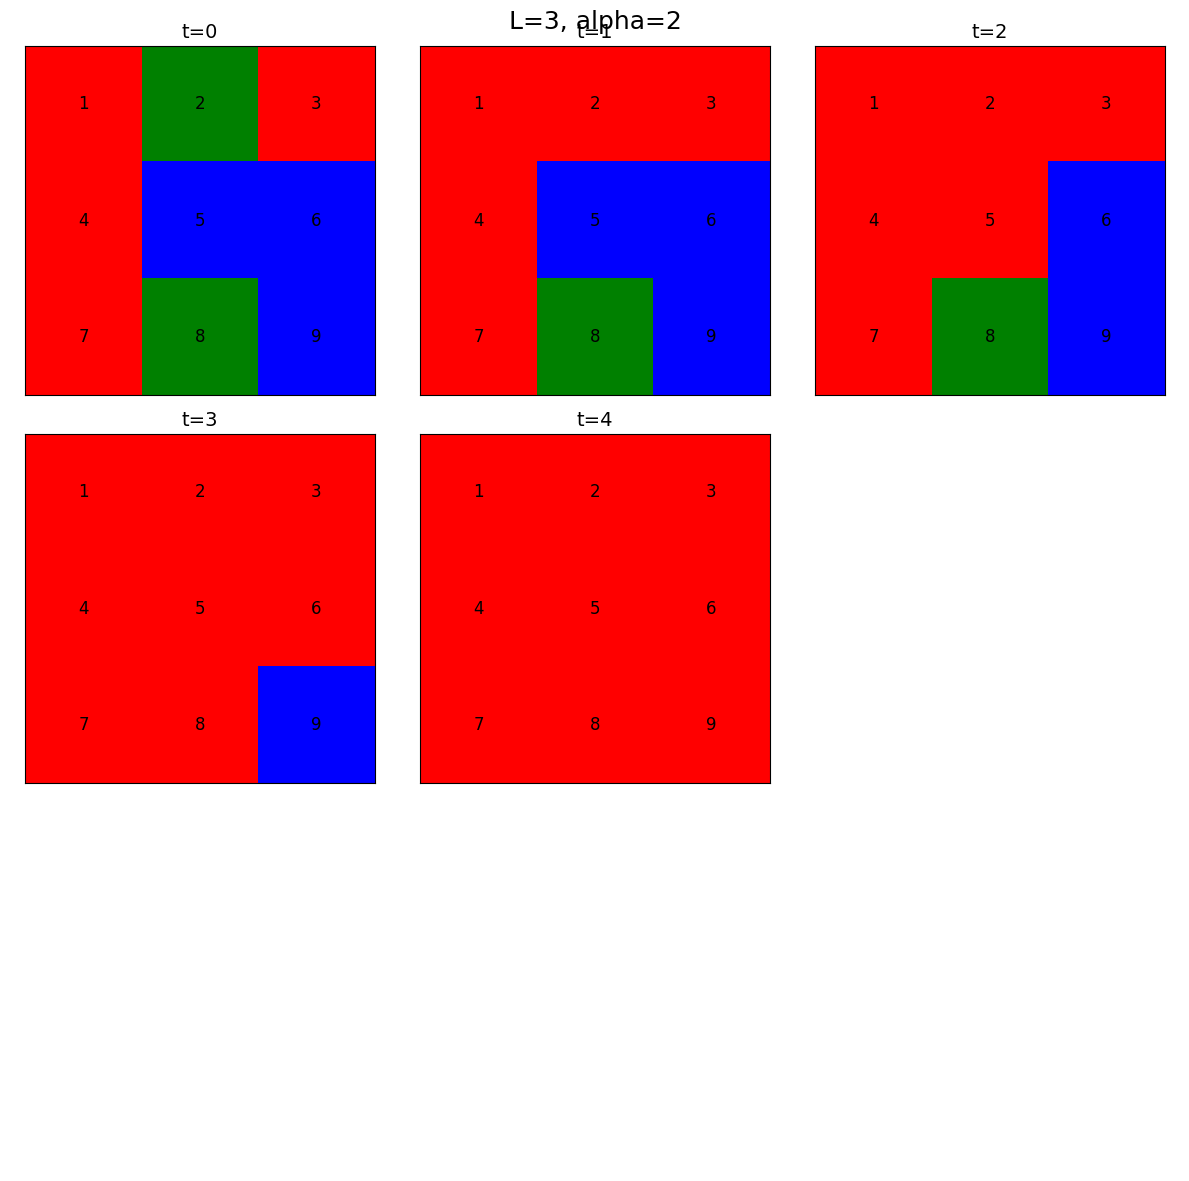

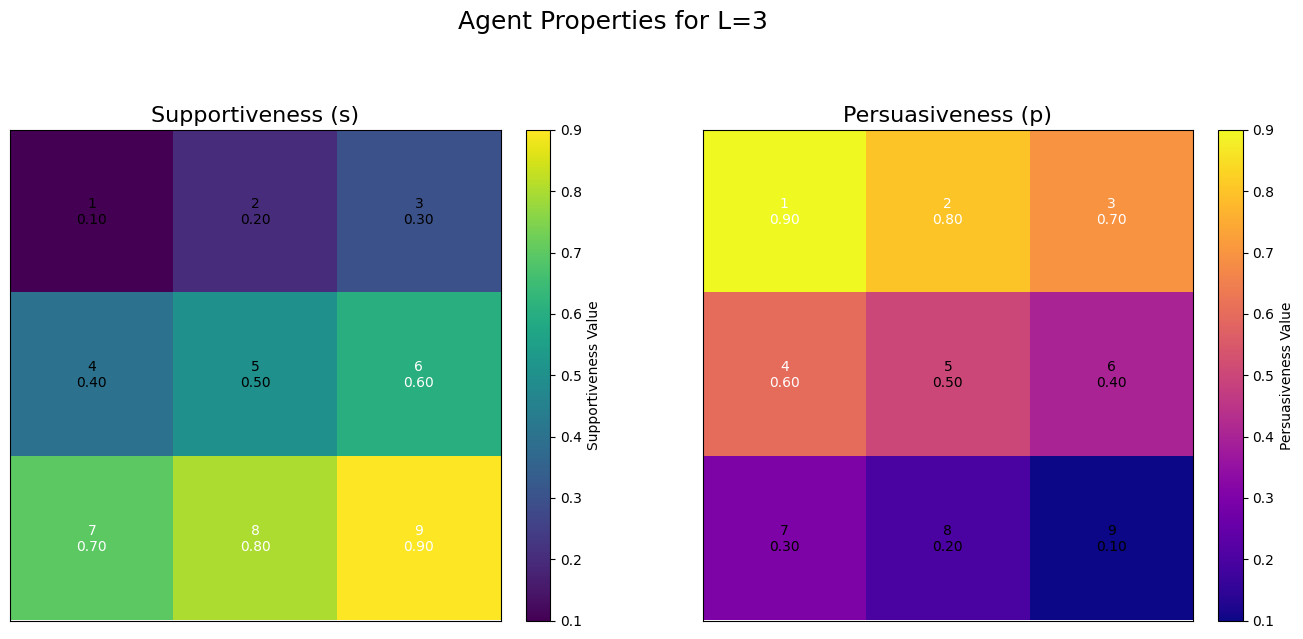

Running Task 2 with alpha=2
Simulation completed at t=14


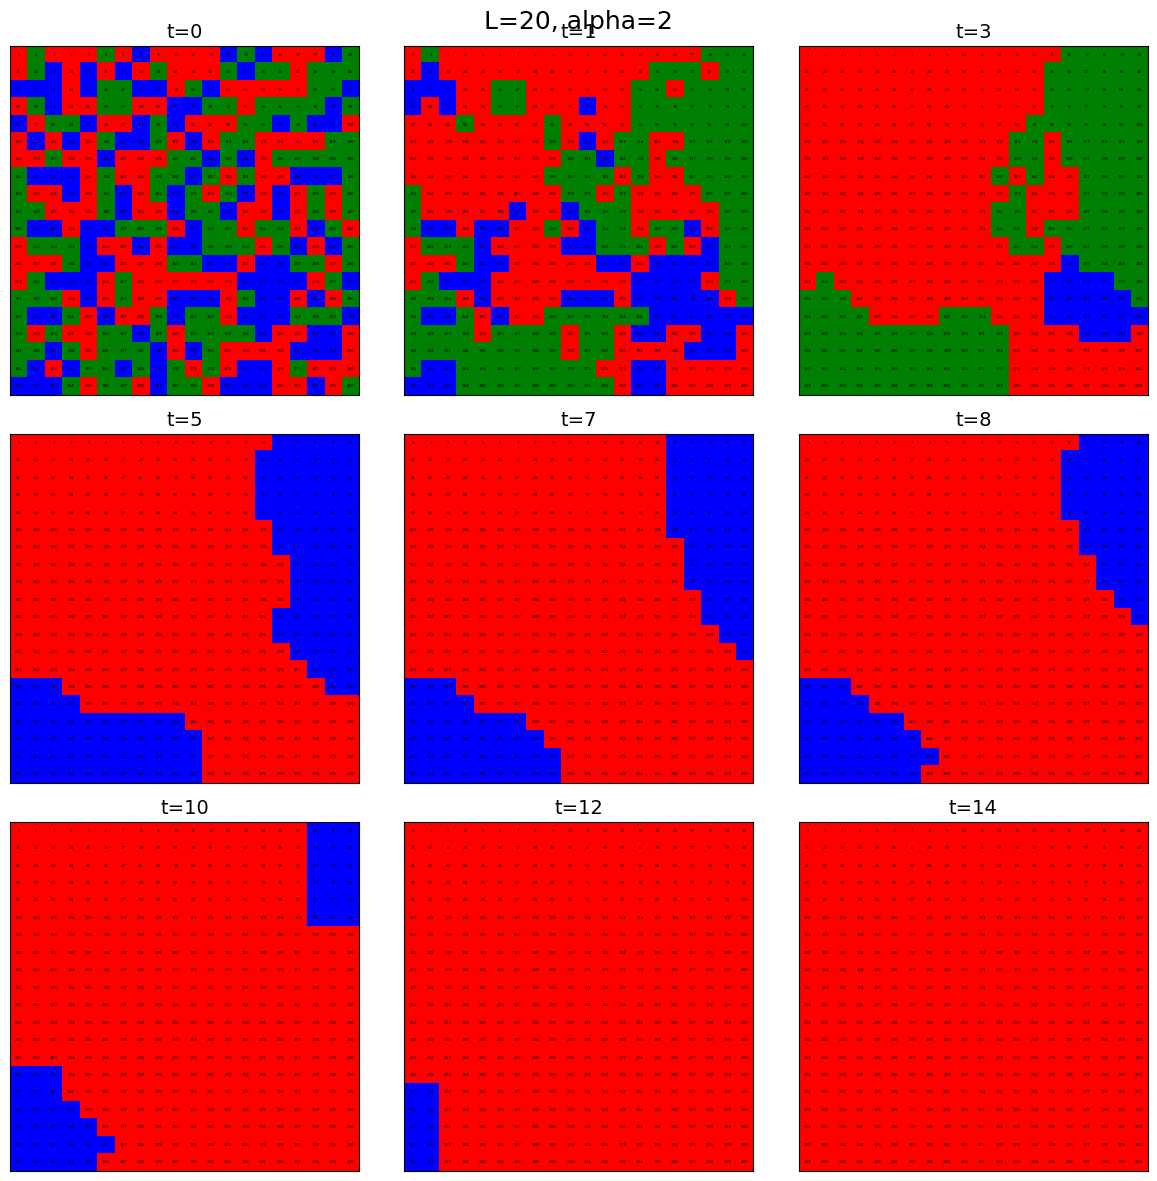

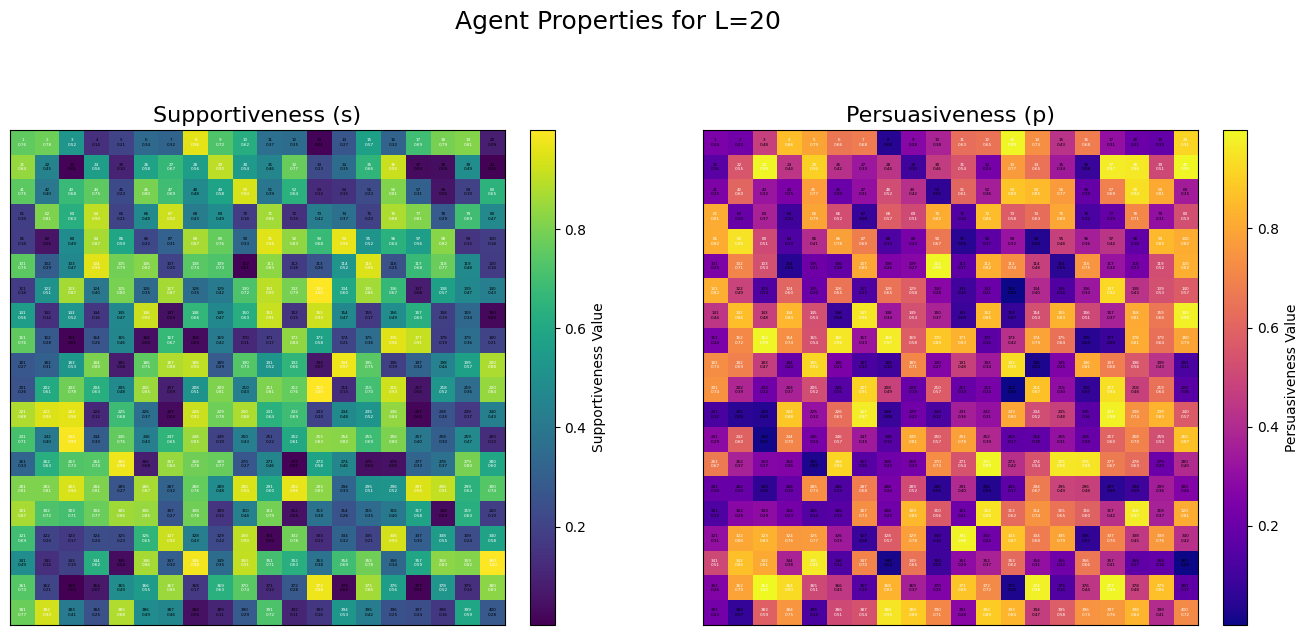

Running Task 2 with alpha=3
Simulation completed at t=50


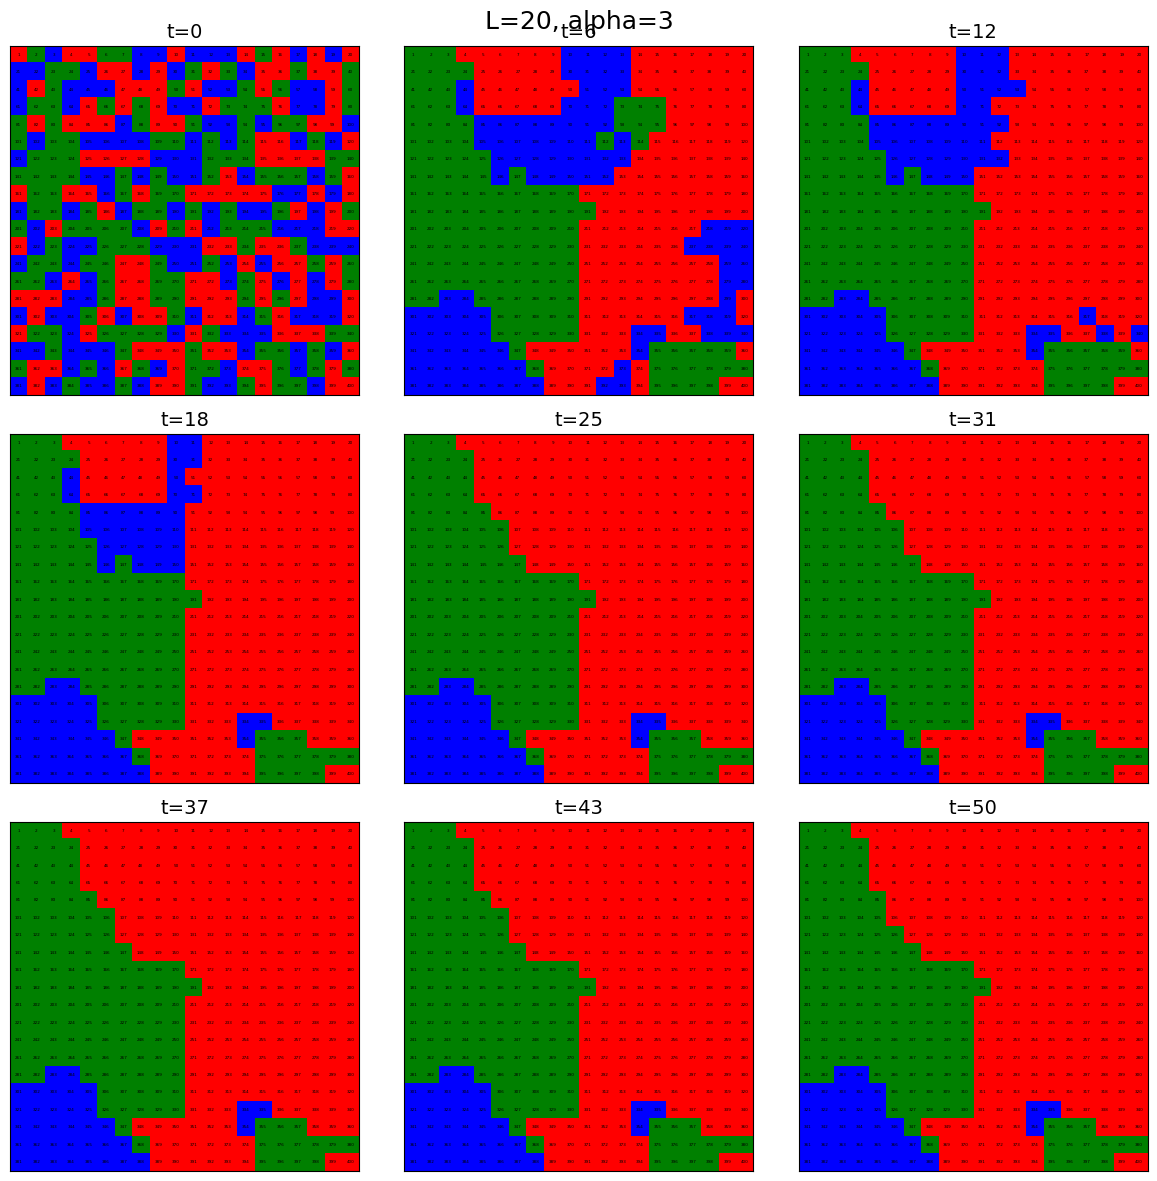

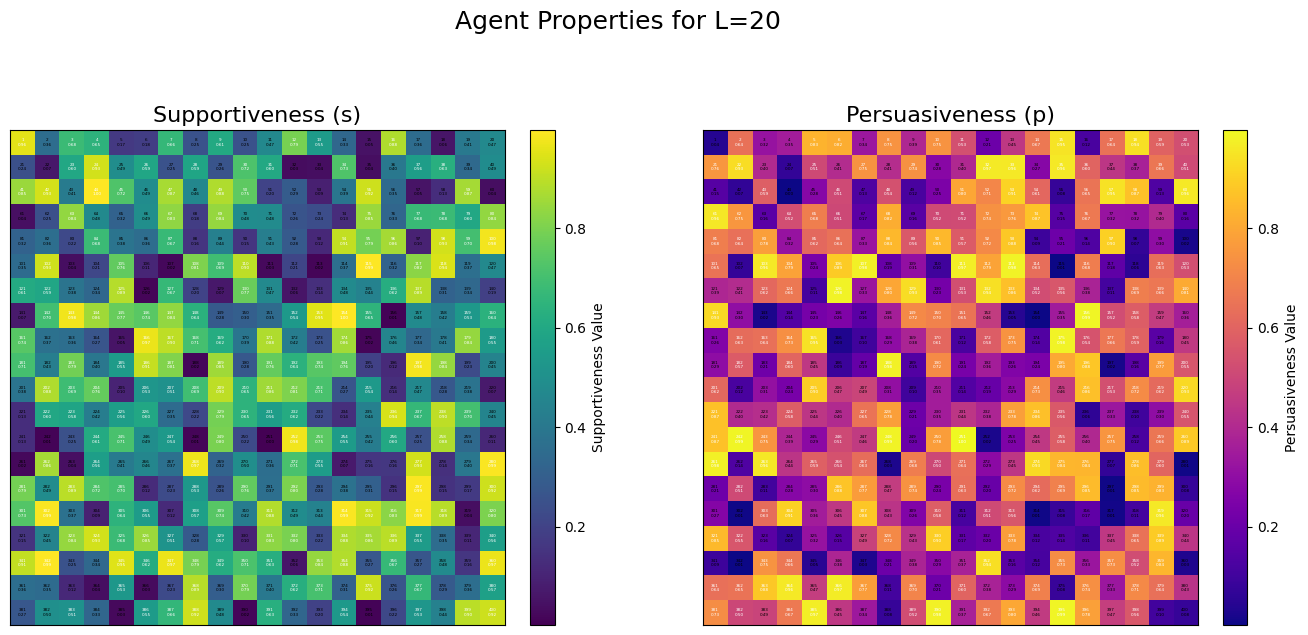

In [42]:
# Task 1 simulation with L=3 and alpha=2
print("Running Task 1 with alpha=2")
history_1_2, props_1_2 = Latane_model(L=3, alpha=2, zad=1)
display_results(history_1_2, L=3, alpha=2, zad=1)
display_agent_properties(L=3, zad=1, agent_properties=props_1_2)

# Task 2 simulations with L=20 and alpha=2 and alpha=3
print("Running Task 2 with alpha=2")
history_2_2, props_2_2 = Latane_model(L=20, alpha=2, zad=2)
display_results(history_2_2, L=20, alpha=2, zad=2)
display_agent_properties(L=20, zad=2, agent_properties=props_2_2)

print("Running Task 2 with alpha=3")
history_2_3, props_2_3 = Latane_model(L=20, alpha=3, zad=2)
display_results(history_2_3, L=20, alpha=3, zad=2)
display_agent_properties(L=20, zad=2, agent_properties=props_2_3)